In [1]:
# All the imports, etc.... this would be a good one to fold up, if I knew how...

%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import json
import logging
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# Use standard numpy fft, since it's thread-safe
import numpy.fft as npfft

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

try:
    # I use dark mode in my notebooks, this makes the plots match :)
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)    
except:
    pass

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

# Add lddecode core modules to path
module_path = os.path.abspath(os.path.join('../lddecode'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
    
from lddecode.utils import *
from lddecode.utils_logging import *
from lddecode.utils_plotting import *
import lddecode.core as core

In [2]:
# This needs to be done after the first block for some reason?
matplotlib.rc('figure', figsize=(40, 24))

In [3]:
logger = init_logging(None)

In [4]:
os.chdir('/home/cpage/ld-decode/git/')

In [5]:
with open('variety.tbc.json', 'r') as fp:
    json_in = fp.read()

tbc_json = json.loads(json_in)
tbc_fp = open('variety.tbc', 'rb')


In [285]:
with open('ve-new.tbc.json', 'r') as fp:
    cjson_in = fp.read()

ctbc_json = json.loads(cjson_in)
ctbc_fp = open('ve-new.tbc', 'rb')


In [121]:
class FilterCache:
    def __init__(self):
        # dict elements: name: ((B, A), [fft conversions])
        self.cache = {}
        
    def addfilter(self, name, B, A=[1.0]):
        if name in self.cache:
            return False
        
        self.cache[name] = ((B, A), [])
        
    def getfilter(self, name, blocksize=None):
        if name not in self.cache:
            return False
        
        if not blocksize:
            return self.cache[name][0], None
        
        for fft in self.cache[name][1]:
            if blocksize == len(fft):
                return self.cache[name][0], fft
    
        newfft = filtfft(self.cache[name][0], blocksize)
        self.cache[name][1].append(newfft)
        
        return self.cache[name][0], newfft
            
    def prefilter(self, data, overlap=512, blocksize=8192):
        numblocks = (len(data) + overlap) // (blocksize - overlap) + 1
        
        start = 0
        dlen  = len(data)
        rv    = [dlen]
        
        while start < len(data):
            blockdata = np.zeros(blocksize, type(data))
            
            if start == 0:
                end = blocksize
                if (end - overlap) > dlen:
                    end = dlen
                    
                blockdata[overlap:] = data[:blocksize-overlap]
                start += blocksize - (overlap * 2)
            else:
                end = blocksize
                if (end + start) > dlen:
                    end = dlen - start
                
                #print(start, end, start + end)
                blockdata[:end] = data[start:start+end]
                
                start = start + blocksize - (overlap * 2)
            
            fblockdata = npfft.fft(blockdata)
            rv.append(fblockdata)
            
            #print(start)
    
        return rv        

    def applyfilter(self, name, pfdata, delay=0, overlap=512, blocksize=8192):
        # todo: handle complex data
        filt = self.getfilter(name, blocksize)
        dlen = pfdata[0]
        
        output = np.zeros(dlen, dtype=np.float32)
        
        for i, blk in enumerate(pfdata[1:]):
            fblk = blk * (filt[1] ** 2.0)
            fdata = npfft.ifft(fblk).real
            
            if i == 0:
                output[:blocksize-overlap-delay] = fdata[overlap+delay:]
            else:
                # XXX: this makes my brain hurt and is probably not right/optimal
                start = (i * (blocksize-(overlap*2))) #- delay
                    
                # It's OK ot use the entire ifft block since the overlap 
                # will be overwritten next block
                end = start + blocksize
                if end > dlen:
                    end = dlen
                                
                blen = (end-delay) - (start+overlap)
                #print(start, end, blen)
                output[start+overlap:end-delay] = fdata[overlap+delay:overlap+delay+blen]
                
                if i == 1:
                    # HACK: account for missing delay bit at the first gap only
                    output[start+overlap-delay:start+overlap] = fdata[overlap:overlap+delay]
            
        return output
        

In [513]:
class CombBase:
    # 1D and 2D filters don't need past/future fields
    MemorySize = [0, 0]
    
    def __init__(self, prev_fields = [], next_fields = [], copy=None):
        # This can be overridden so that the entire filter chain is available,
        # preventing re-running of comb filters
        self.filter_output = {}
        self.rawdata       = None
        self.indata        = None
        self.name          = None

        if copy:
            for key, value in copy.__dict__.items():
                setattr(self, key, value)

        self.prev_fields = prev_fields
        self.next_fields = next_fields
        
        self.fsc      = (315.0 / np.double(88.0))
        self.filter_chain  = []
    
    def load(self, tbc_fp, tbc_json, field_number):
        if self.indata is not None:
            raise Exception("Can only load once per Comb field object")
        self.vp   = tbc_json['videoParameters']
        self.info = tbc_json['fields'][field_number]
        
        vid_range     = self.vp['white16bIre'] - self.vp['black16bIre']
        self.irescale = 100 / vid_range
        
        self.fieldlen = self.vp['fieldWidth'] * self.vp['fieldHeight']
        
        tbc_fp.seek((self.fieldlen * 2) * field_number)
        self.rawdata = np.frombuffer(tbc_fp.read(self.fieldlen * 2), np.uint16)
        self.indata  = (self.rawdata - self.vp['black16bIre']) * self.irescale
        
        if not (len(self.rawdata) == self.fieldlen):
            raise Exception("failed to read field")
            
        self.filter_output = {}

    def getlinephase(self, line):
        """ determine if a line has positive color burst phase.
            This is based on line # and field phase ID """
        fieldID = self.info['fieldPhaseID']

        # adjust for these lines being 0-based
        if ((line + 1) % 2) == 0:
            return (fieldID == 1) | (fieldID == 4)
        else:
            return (fieldID == 2) | (fieldID == 3)

    # Colorspace conversion
    def YIQtoRGB(self, Y, I, Q):
        R = Y + ( .956 * Q) + (.621 * I)
        G = Y - ( .272 * Q) - (.647 * I)
        B = Y - (1.106 * Q) + (1.703 * I)

        #return Y, Y, Y
        return R, G, B

    def split_chroma(self, cdata):
        plines = 263
        
        cdata = cdata.reshape((plines, 910))
        
        si = np.zeros((plines, 455), dtype=np.double)
        sq = np.zeros((plines, 455), dtype=np.double)

        for line in range(0, 263):
            linephase = self.getlinephase(line)

            si[line] = cdata[line][::2].copy()
            sq[line] = cdata[line][1::2].copy()

            if not linephase:
                si[line][0::2] = -si[line][0::2]
                sq[line][1::2] = -sq[line][1::2]
            else:
                si[line][1::2] = -si[line][1::2]
                sq[line][0::2] = -sq[line][0::2]
                
        return si, sq
               
    def yc_to_rgb(self, rgb_out, y, c, interlace=False):
        plines = 263
        y_out = y.reshape((263, 910))
        #y_out = y.reshape(263 * 910)
    
        spliti, splitq = self.split_chroma(c)
        #print(y_out.shape, i.shape, q.shape)
    
        i_out = spliti.reshape(263 * 455)
        q_out = splitq.reshape(263 * 455)
        
        i_out2 = scale(i_out, 0, len(i_out), len(i_out)*2).reshape((263, 910))
        q_out2 = scale(q_out, 0, len(q_out), len(q_out)*2).reshape((263, 910))
    
        interlace_field = 0 if self.info['isFirstField'] else 1
        
        for l in range(0, plines):
            R, G, B = self.YIQtoRGB(y_out[l], i_out2[l], q_out2[l])

            if interlace:
                lineout = rgb_out[(l * 2)+interlace_field]
            else:
                lineout = rgb_out[l]
            
            lineout[:,0] = R
            lineout[:,1] = G
            lineout[:,2] = B
            
        return rgb_out
    
    def process_chain(self):
        obj_name = self.__class__.__name__
        
        print(obj_name, self.filter_output)
        
        if obj_name in self.filter_output:
            return self.filter_output[obj_name]
        
        for fc in self.filter_chain:
            if isinstance(fc, tuple):
                fclass = fc[0]
                fargs  = fc[1].copy()
                fargs['copy'] = self
                print(fargs)
            else:
                print('nottup', fc)
                fclass = fc
                fargs = {'copy': self}
                
            fobj = fclass(**fargs)
            filter_name = fclass.__name__ if not fobj.name else fobj.name
            
            if filter_name not in self.filter_output:
                self.filter_output[filter_name] = fobj.process()
        
        self.filter_output[obj_name] = self.process()
        return self.filter_output[obj_name]

class Comb1D_Notch(CombBase):
    def __init__(self, cband = 0.6, *args, **kwargs):
        super(Comb1D_Notch, self).__init__(*args, **kwargs)

        self.name   = f'Comb1D_Notch_{cband}'
        
        self.ynotch = sps.firwin(63, [self.fsc-cband, self.fsc+cband], pass_zero=True, fs=self.fsc*4)
        self.cnotch = sps.firwin(63, [self.fsc-cband, self.fsc+cband], pass_zero=False, fs=self.fsc*4)
        
        self.fc = FilterCache()
        self.fc.addfilter('ynotch', self.ynotch)
        self.fc.addfilter('cnotch', self.cnotch)
        
    def process(self):
        pfilt = self.fc.prefilter(self.indata)
        
        self.ydata = self.fc.applyfilter('ynotch', pfilt, delay=len(self.ynotch)-1)
        self.cdata = self.indata - self.ydata
    
        return {'obj': self, 
                'Y': self.ydata.reshape((263,910)), 
                'C': self.cdata.reshape((263,910))}
        
        #return self.yc_to_rgb(self.ydata.reshape((263,910)), self.cdata.reshape((263,910)))

In [579]:
class Comb2D_3LA(CombBase):
    def __init__(self, cband=0.6, order=63, adaptive=True, *args, **kwargs):
        super(Comb2D_3LA, self).__init__(*args, **kwargs)
        
        self.cband = cband
        self.filter_chain = [(Comb1D_Notch, {'cband': cband})]
        self.adaptive = adaptive

        # This is used for a post-split check
        self.fc = FilterCache()
        self.ynotch = sps.firwin(order, [self.fsc-cband, self.fsc+cband], pass_zero=True, fs=self.fsc*4)
        self.cnotch = sps.firwin(order, [self.fsc-cband, self.fsc+cband], pass_zero=False, fs=self.fsc*4)

        self.fc.addfilter('ynotch', self.ynotch)
        self.fc.addfilter('cnotch', self.cnotch)
        
    def process(self):
        YC1 = cf.filter_output[f'Comb1D_Notch_{self.cband}']
        
        ldata = self.indata.reshape((263, 910))
        
        self.ydata = np.zeros_like(ldata)
        self.cdata = np.zeros_like(ldata)

        # from the LD S2 service manual
        for i in range(1, 262 - 1):
            a = ldata[i - 1]
            b = ldata[i]
            c = ldata[i + 1]

            self.ydata[i] = ( a + 2*b + c) / 4
            self.cdata[i] = (-a + 2*b - c) / 4
            
        pfilt         = self.fc.prefilter(self.cdata.reshape((263*910)))
        self.cnotched = self.fc.applyfilter('ynotch', pfilt, delay=len(self.ynotch)-1)
        self.cnotched = self.cnotched.reshape((263, 910))

        if not self.adaptive:
            return {'obj': self, 'Y': self.ydata, 'C': self.cdata}
        
        for l in range(1, 262 - 1):
            adj = np.abs(self.cnotched[l])
            adj = np.clip(adj - 2.5, 0, 5) / 5
                        
            self.ydata[l] += self.cnotched[l]
            self.cdata[l] -= self.cnotched[l]
        
            self.ydata[l] = (adj * YC1['Y'][l]) + ((1 - adj) * self.ydata[l])
            self.cdata[l] = (adj * YC1['C'][l]) + ((1 - adj) * self.cdata[l])
        
        for i in [0, 1, 261, 262]:
            self.ydata[i] = YC1['Y'][i]
            self.cdata[i] = YC1['C'][i]

        return {'obj': self, 'Y': self.ydata, 'C': self.cdata}


In [711]:
class Comb2D_3LA2(CombBase):
    def __init__(self, cband=0.6, order=63, adaptive=True, *args, **kwargs):
        super(Comb2D_3LA2, self).__init__(*args, **kwargs)
        
        self.cband = cband
        self.filter_chain = [(Comb1D_Notch, {'cband': cband})]
        self.adaptive = adaptive

        # This is used for a post-split check
        self.fc = FilterCache()
        self.cnotch = sps.firwin(order, [self.fsc-cband, self.fsc+cband], pass_zero=False, fs=self.fsc*4)
        self.ynotch = sps.firwin(order, [self.fsc-.6, self.fsc+.6], pass_zero=True, fs=self.fsc*4)

        self.fc.addfilter('cnotch', self.cnotch)
        self.fc.addfilter('ynotch', self.ynotch)
        
    def process1H(self, ldata, yoffset, xoffset = 0):
        ydata = np.zeros_like(ldata)
        cdata = np.zeros_like(ldata)
        
        # from the LD S2 service manual
        for i in range(0, 263):
            if not inrange(i + yoffset, 0, 262):
                continue
                
            a = ldata[i]
            if xoffset:
                b = np.roll(ldata[i + yoffset], xoffset)
            else:
                b = ldata[i + yoffset]

            ydata[i] = (a + b) / 2
            cdata[i] = (a - b) / 2
            
        return ydata, cdata      
        
    def process(self):
        YC1 = cf.filter_output[f'Comb1D_Notch_{self.cband}']
        
        ldata = self.indata.reshape((263, 910))
        self.ydata = np.zeros_like(ldata)
        self.cdata = np.zeros_like(ldata)
        self.adjs  = np.zeros_like(ldata)

        for i in [0, 1, 261, 262]:
            self.ydata[i] = YC1['Y'][i]
            self.cdata[i] = YC1['C'][i]

        self.ydata1, self.cdata1 = {}, {}
        for o in [-2, -1, 1, 2]:
            self.ydata1[o], self.cdata1[o] = self.process1H(ldata, o)
        
        self.ydataL, self.cdataL = self.process1H(ldata, 0, -2)
        self.ydataR, self.cdataR = self.process1H(ldata, 0,  2)
        self.ydata, self.cdata = self.process1H(ldata, 0,  2)
        
        #for l in range(1, 262 - 1):
            #self.ydata[l] = (self.ydata1[-1][l] + self.ydata1[1][l]) / 2 
            #self.cdata[l] = (self.cdata1[-1][l] + self.cdata1[1][l]) / 2 
            
        if not self.adaptive:
            return {'obj': self, 'Y': self.ydata, 'C': self.cdata}
  
        pfilt         = self.fc.prefilter(self.cdata.reshape((263*910)))
        self.cnotched = self.fc.applyfilter('ynotch', pfilt, delay=len(self.ynotch)-1)
        self.cnotched = self.cnotched.reshape((263, 910))

        for l in range(1, 262 - 1):
            self.ydata[l] += self.cnotched[l]
            self.cdata[l] -= self.cnotched[l]

            adj = np.abs(self.cnotched[l])
            adj = np.clip(adj - 2.5, 0, 5) / 5
            self.adjs[l] = adj

            self.ydata[l] = (adj * YC1['Y'][l]) + ((1 - adj) * self.ydata[l])
            self.cdata[l] = (adj * YC1['C'][l]) + ((1 - adj) * self.cdata[l])
        
        return {'obj': self, 'Y': self.ydata, 'C': self.cdata}


Comb2D_3LA2 {}
{'cband': 0.9, 'copy': <__main__.Comb2D_3LA2 object at 0x7f088b67d5a0>}
Comb2D_3LA2 {}
{'cband': 0.9, 'copy': <__main__.Comb2D_3LA2 object at 0x7f088b67e920>}


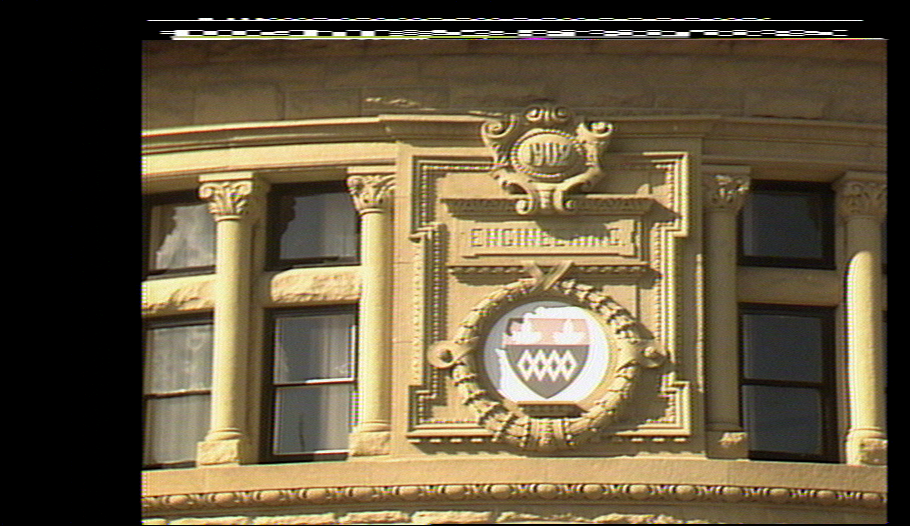

In [715]:
#cf = NotchComb()
cf = Comb2D_3LA()
rgb_out_frame = np.zeros((526, 910, 3), dtype=np.float32)
rgb_out_field = np.zeros((263, 910, 3), dtype=np.float32)

if True:
    f = 11350
    for fnum in [(f*2), (f*2)+1]:
        cband=0.9
        cf = Comb2D_3LA2(cband=cband,order=31,adaptive=True)
        cf.load(tbc_fp, tbc_json, fnum)
        YC = cf.process_chain()
        YC1 = cf.filter_output[f'Comb1D_Notch_{cband}']
        cf.yc_to_rgb(rgb_out_frame, YC['Y'], YC['C'], interlace=True)
        cf.yc_to_rgb(rgb_out_field, YC['Y'], YC['C'], interlace=False)
else:
    f = 13
    for fnum in [(f*2), (f*2)+1]:
        cband=1.5
        cf = Comb2D_3LA2(cband=cband,order=31,adaptive=True)
        cf.load(ctbc_fp, ctbc_json, fnum)
        YC = cf.process_chain()
        YC1 = cf.filter_output[f'Comb1D_Notch_{cband}']
        cf.yc_to_rgb(rgb_out_frame, YC['Y'], YC['C'], interlace=True)
        cf.yc_to_rgb(rgb_out_field, YC['Y'], YC['C'], interlace=False)

rgb_out16_frame = (rgb_out_frame * 655.35).clip(0,65535).reshape((526, 910*3)).astype(np.uint16)
rgb_out16_field = (rgb_out_field * 655.35).clip(0,65535).reshape((263, 910*3)).astype(np.uint16)

draw_u16_image(rgb_out16_frame)

# np.std(cf.ynotched[l])

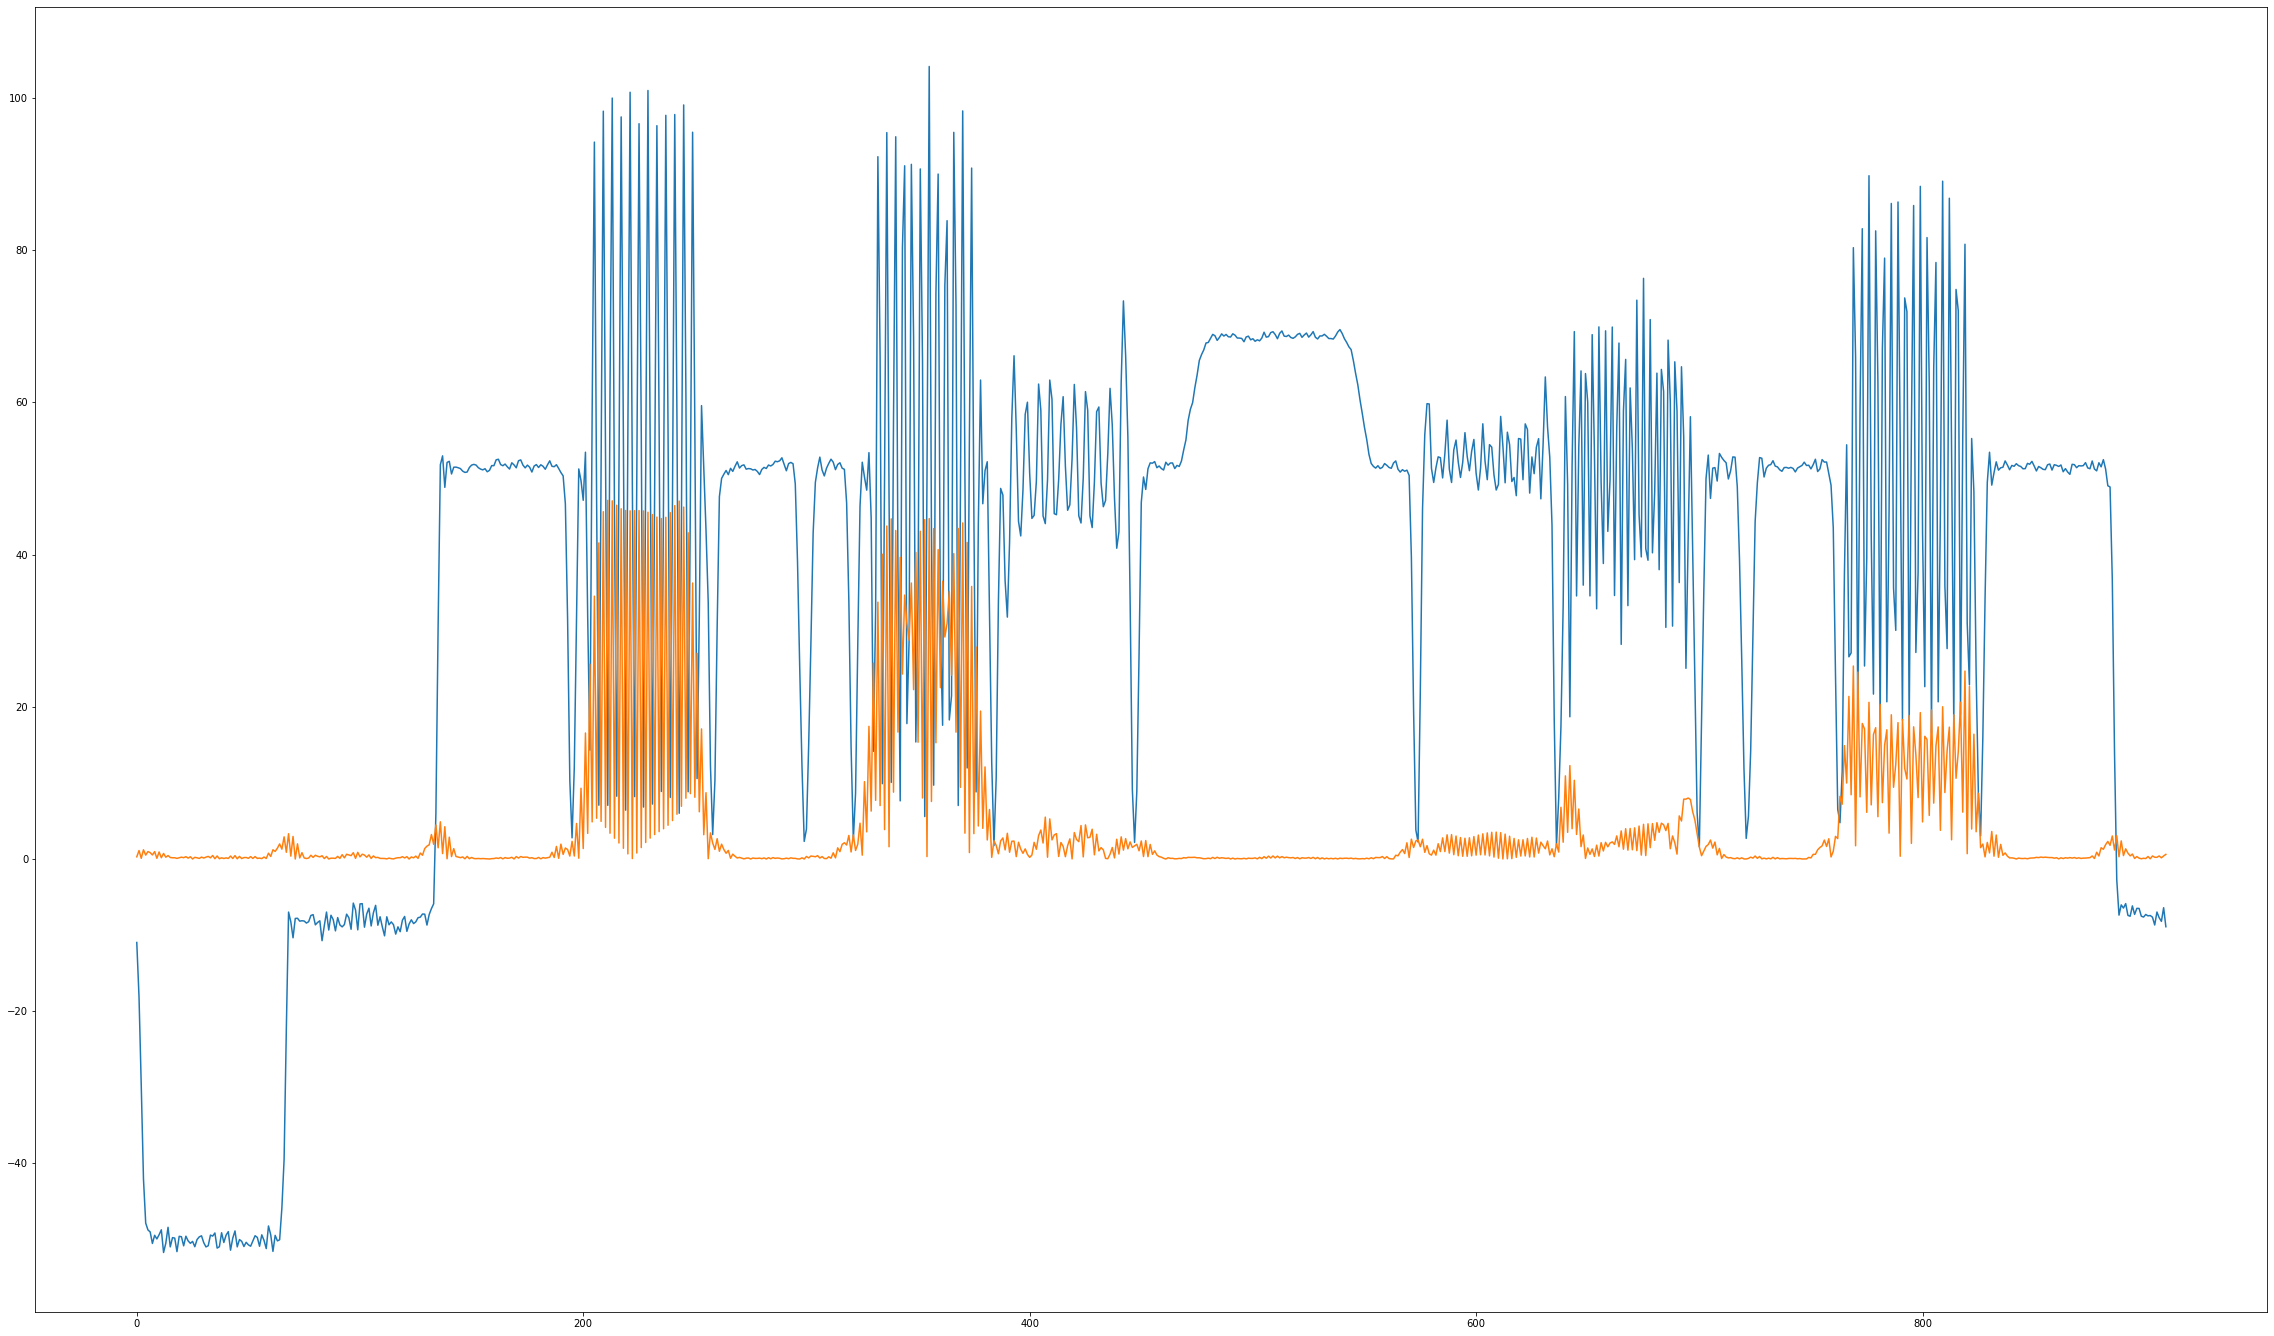

In [694]:
l = 48
l = 238
l = 60
#l = 60
sl = slice(910*l,910*(l+1))
#plt.plot(YC['Y'][l])
#plt.plot(YC['C'][l])
#plt.plot(cf.cnotched[l])
plt.plot(cf.ydata[l])
#plt.plot(cf.cdata[l])
#plt.plot(cf.adjs[l])
#plt.plot(np.abs(cf.ynotched[l]))
plt.plot(np.abs(cf.ynotched[l]))
#plt.plot(cf.cdataP[l])
#plt.plot(cf.cdataN[l])
#plt.plot(YC['Y'][l-2])
#plt.plot(YC['Y'][l+2])

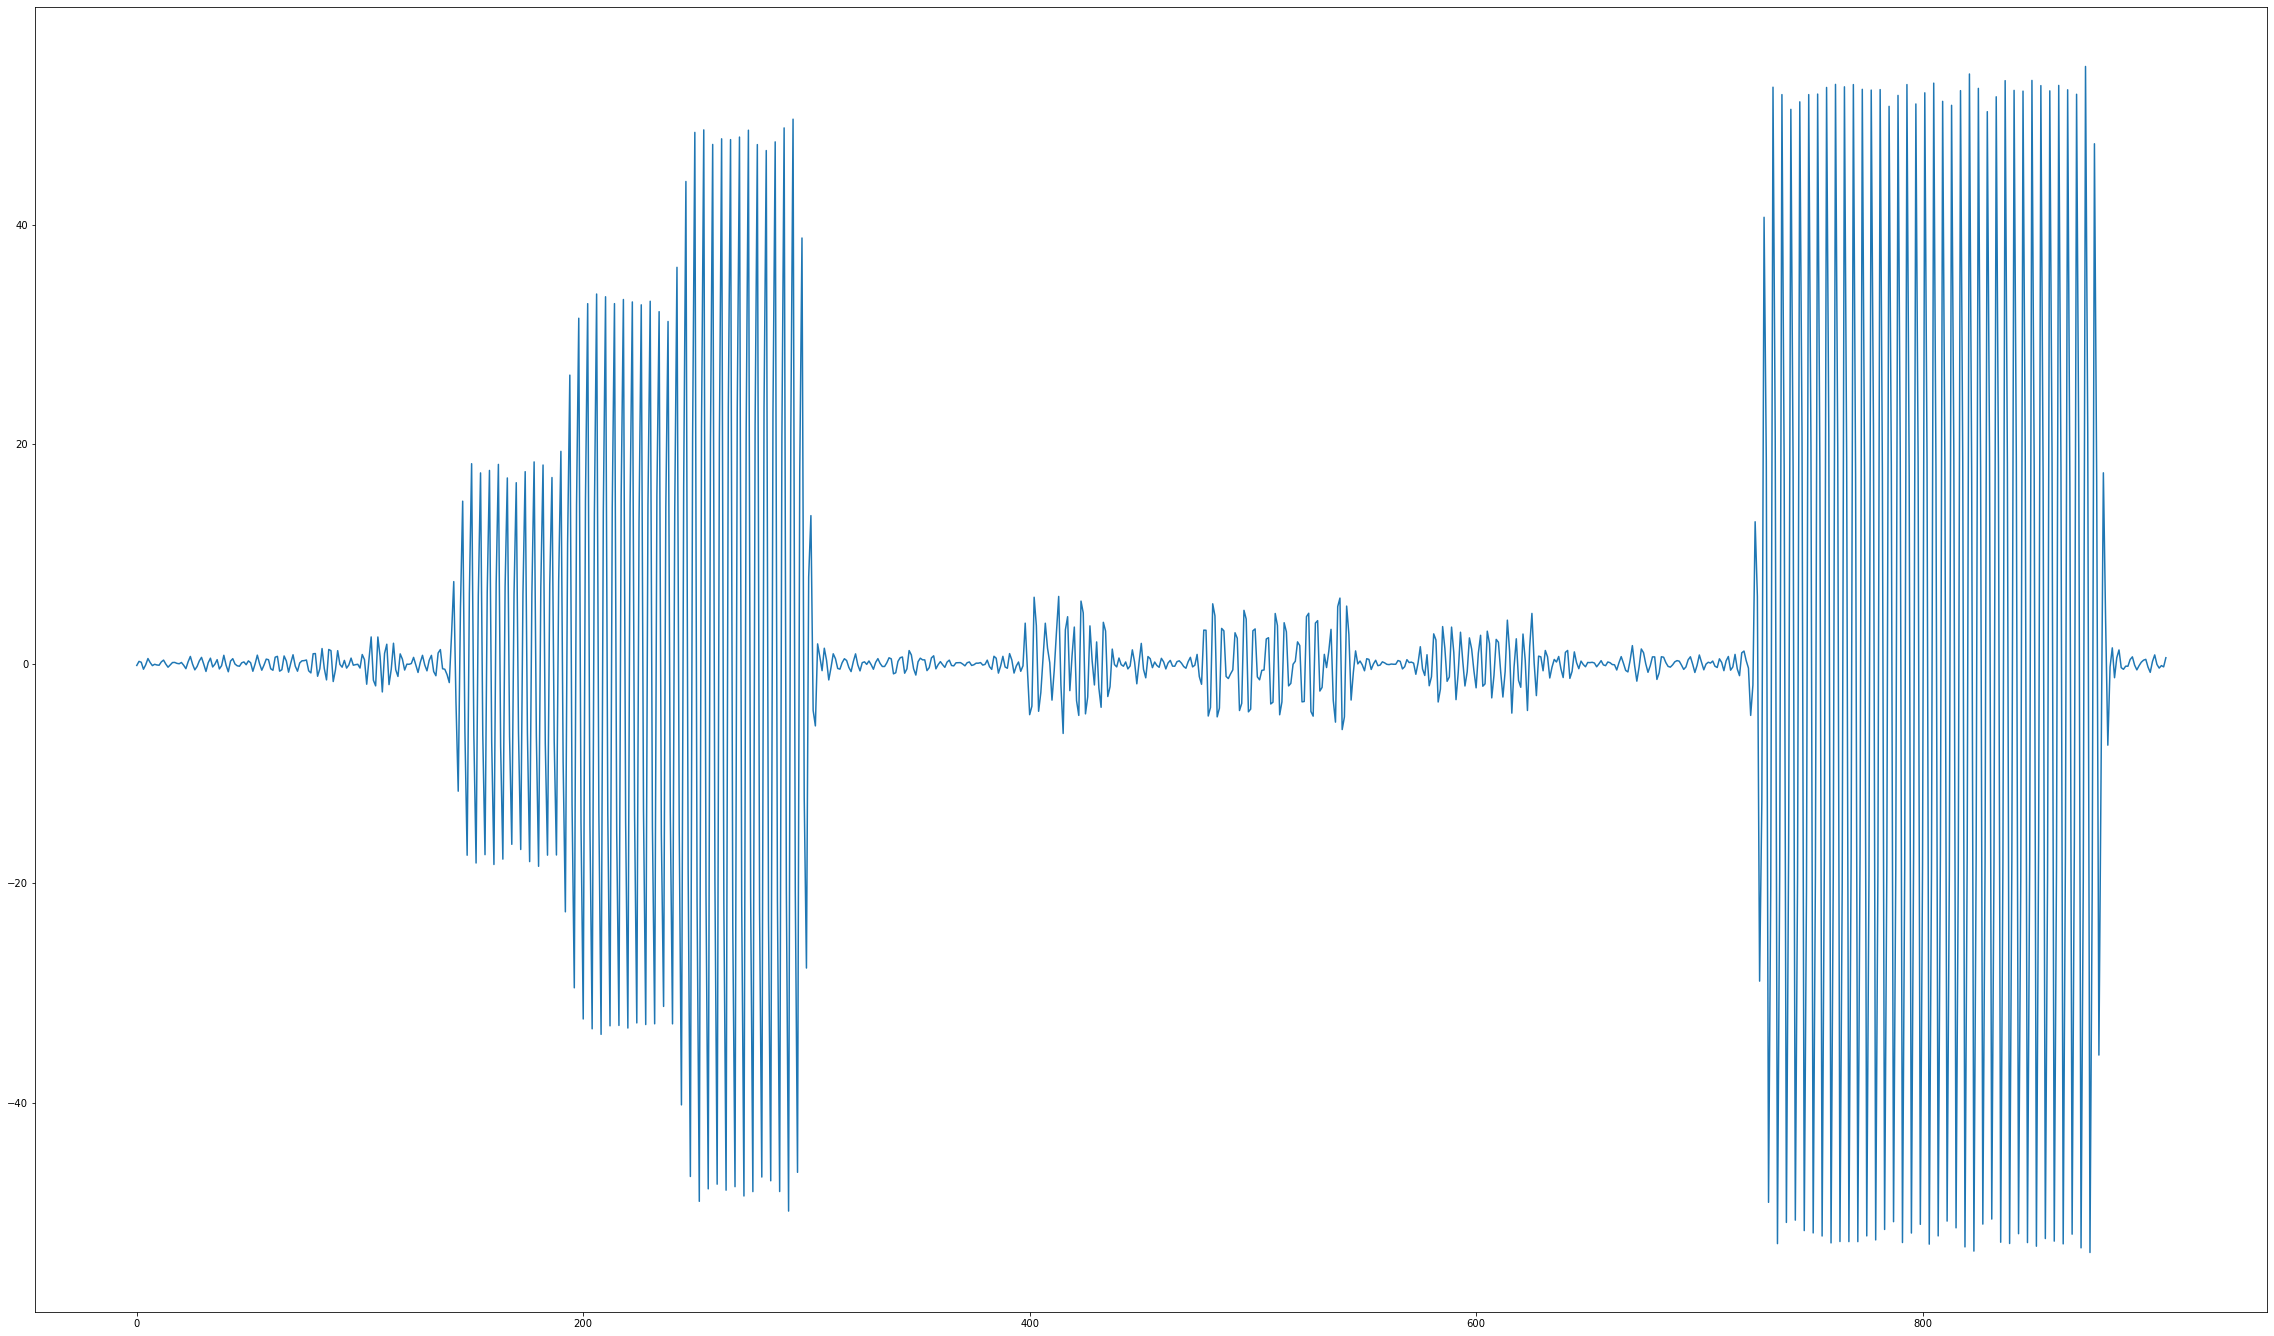

In [500]:
plt.rcParams['axes.labelcolor'] = 'red'
#plt.plot(YC['C'][l])
#plt.plot(YC1['C'][l])
l = 238

d   = YC['C'][l+2] - YC['C'][l]
adj = np.clip(np.abs(d) - 15, 0, 10) / 10
z = (adj * YC1['C'][l]) + ((1 - adj) * YC['C'][l])
#plt.plot(YC1['C'][l])
plt.plot(d)
#plt.plot(adj)
#plt.plot()

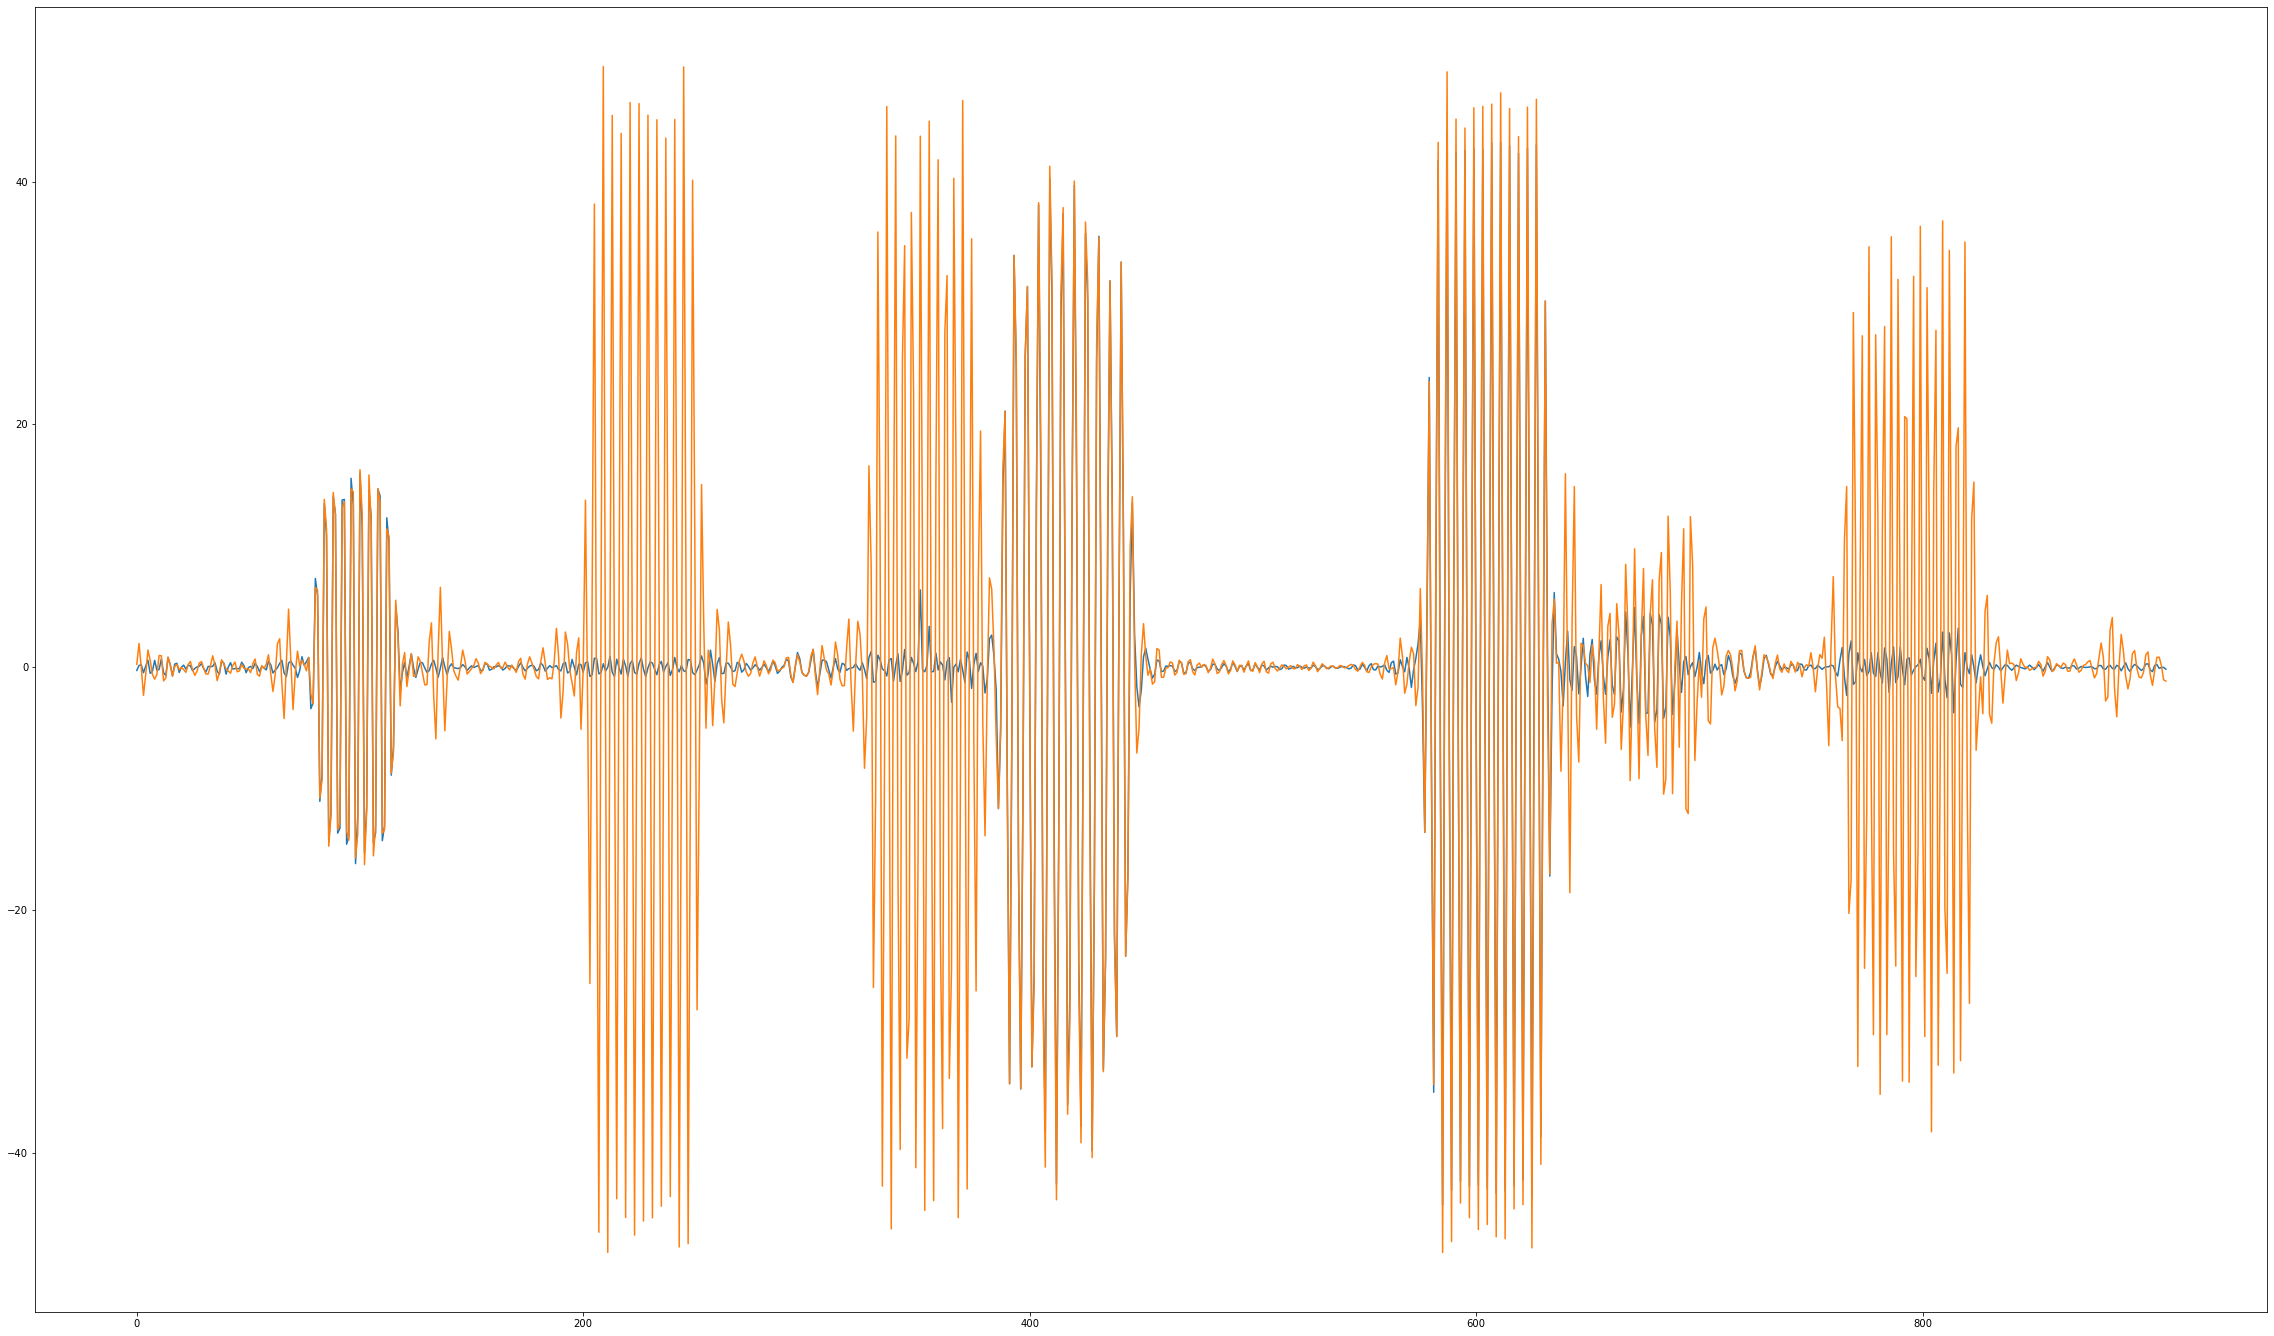

In [476]:
l = 60
sl = slice(910*l,910*(l+1))
plt.plot(YC['C'][l])
plt.plot(YC1['C'][l])
#plt.plot(YC['Y'][l-2])
#plt.plot(YC['Y'][l+2])

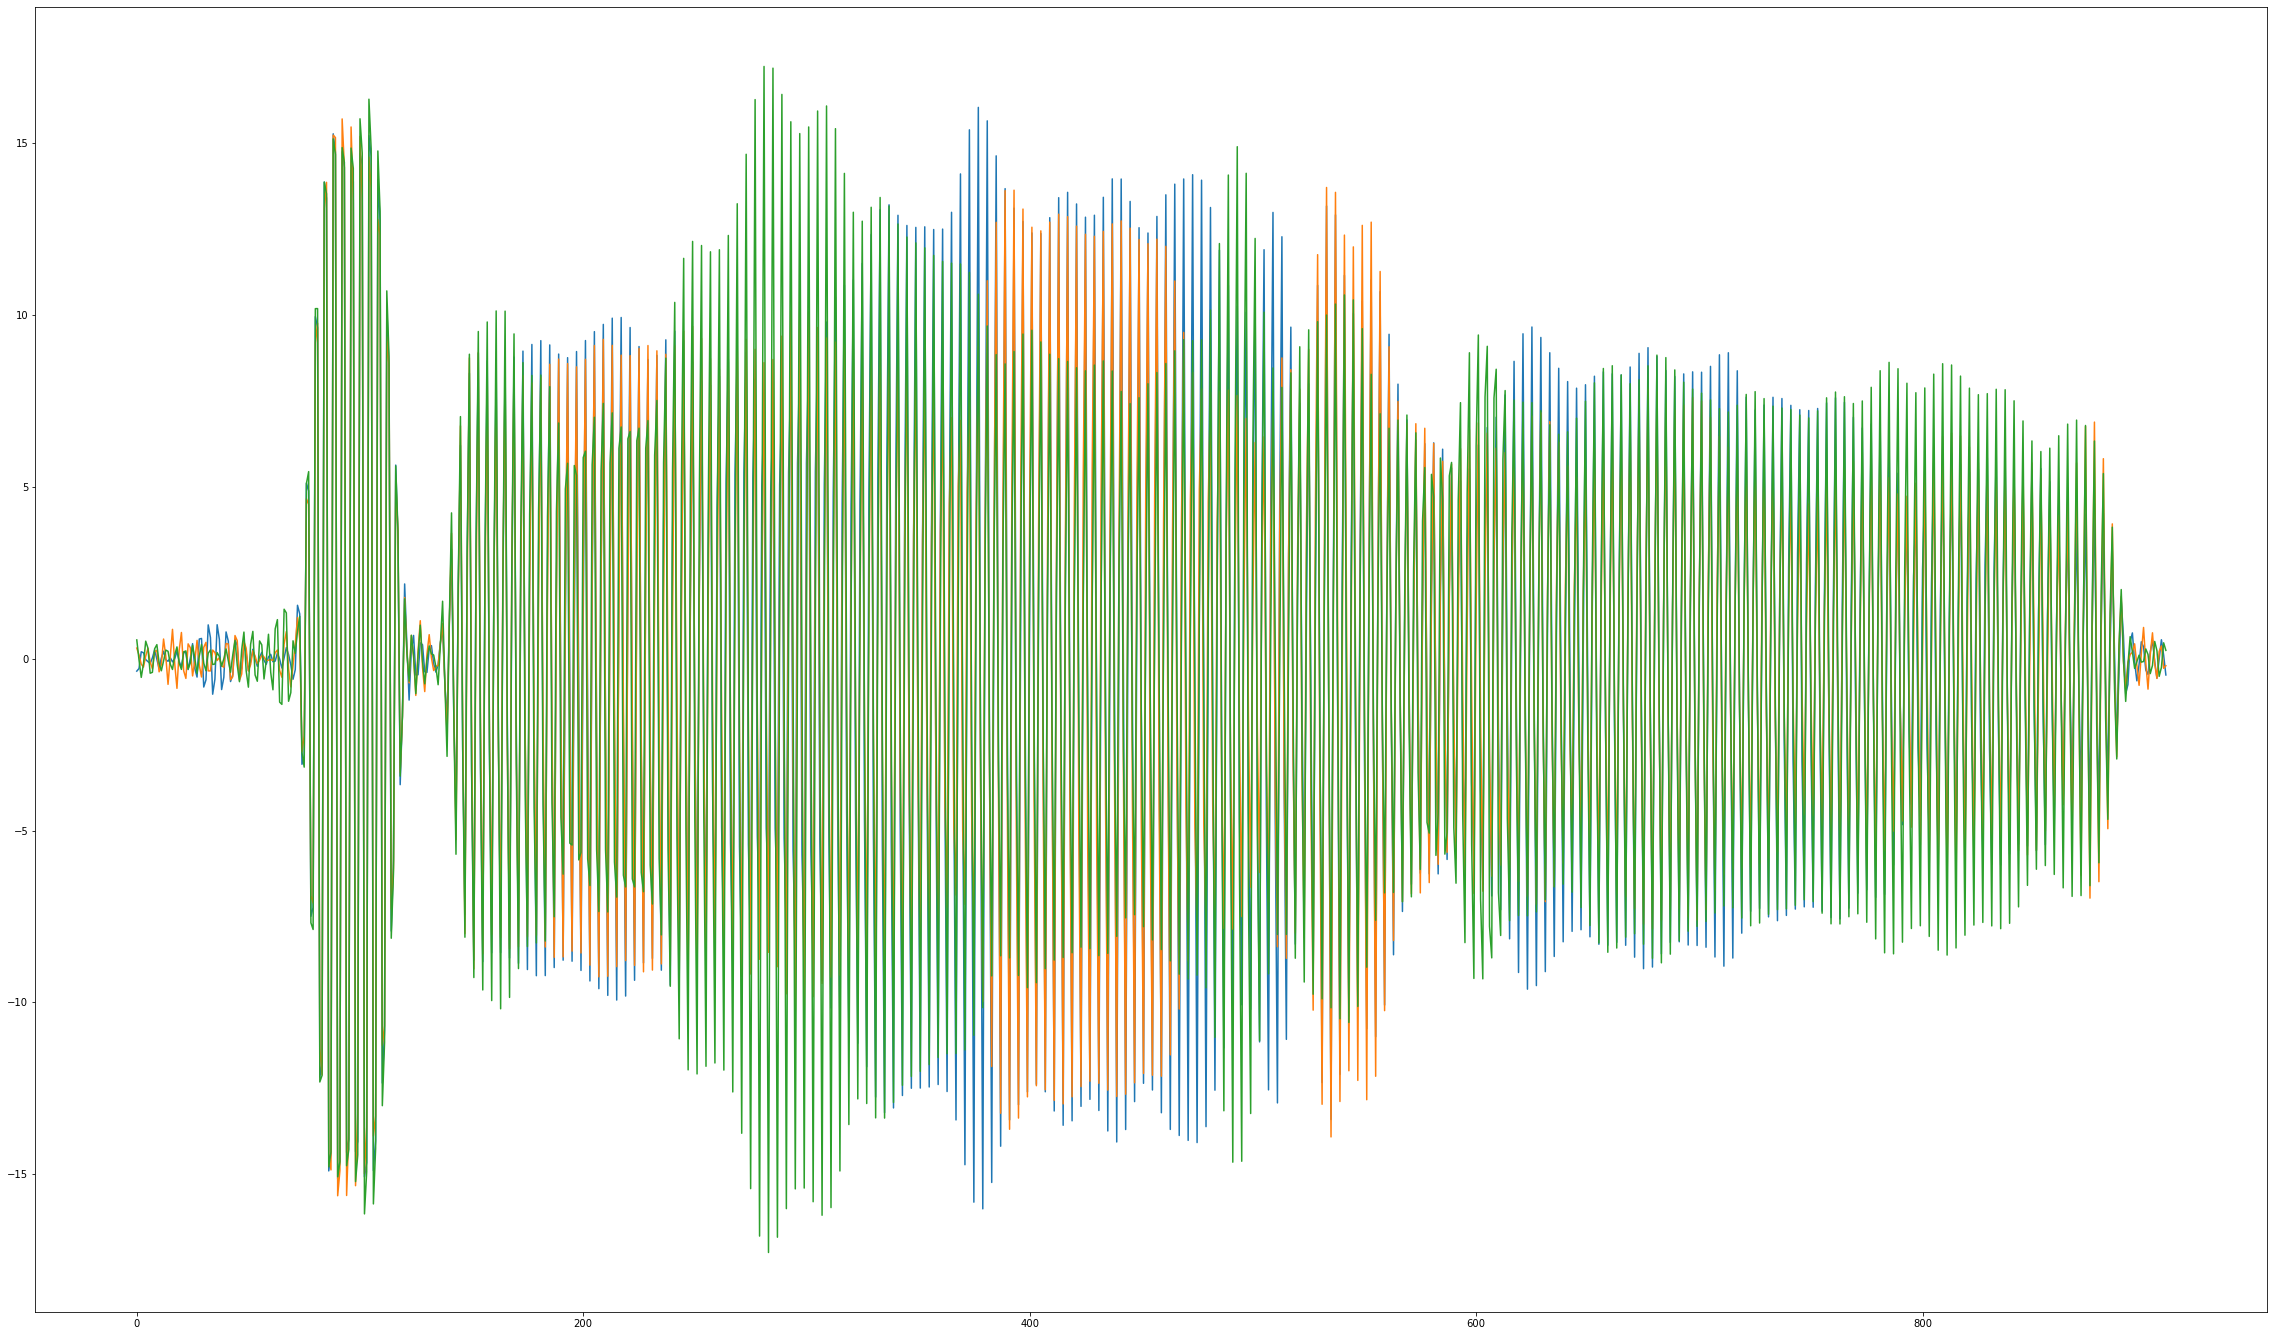

In [224]:
plt.plot(YC['C'][l])
plt.plot(YC['C'][l-2])
plt.plot(YC['C'][l+2])


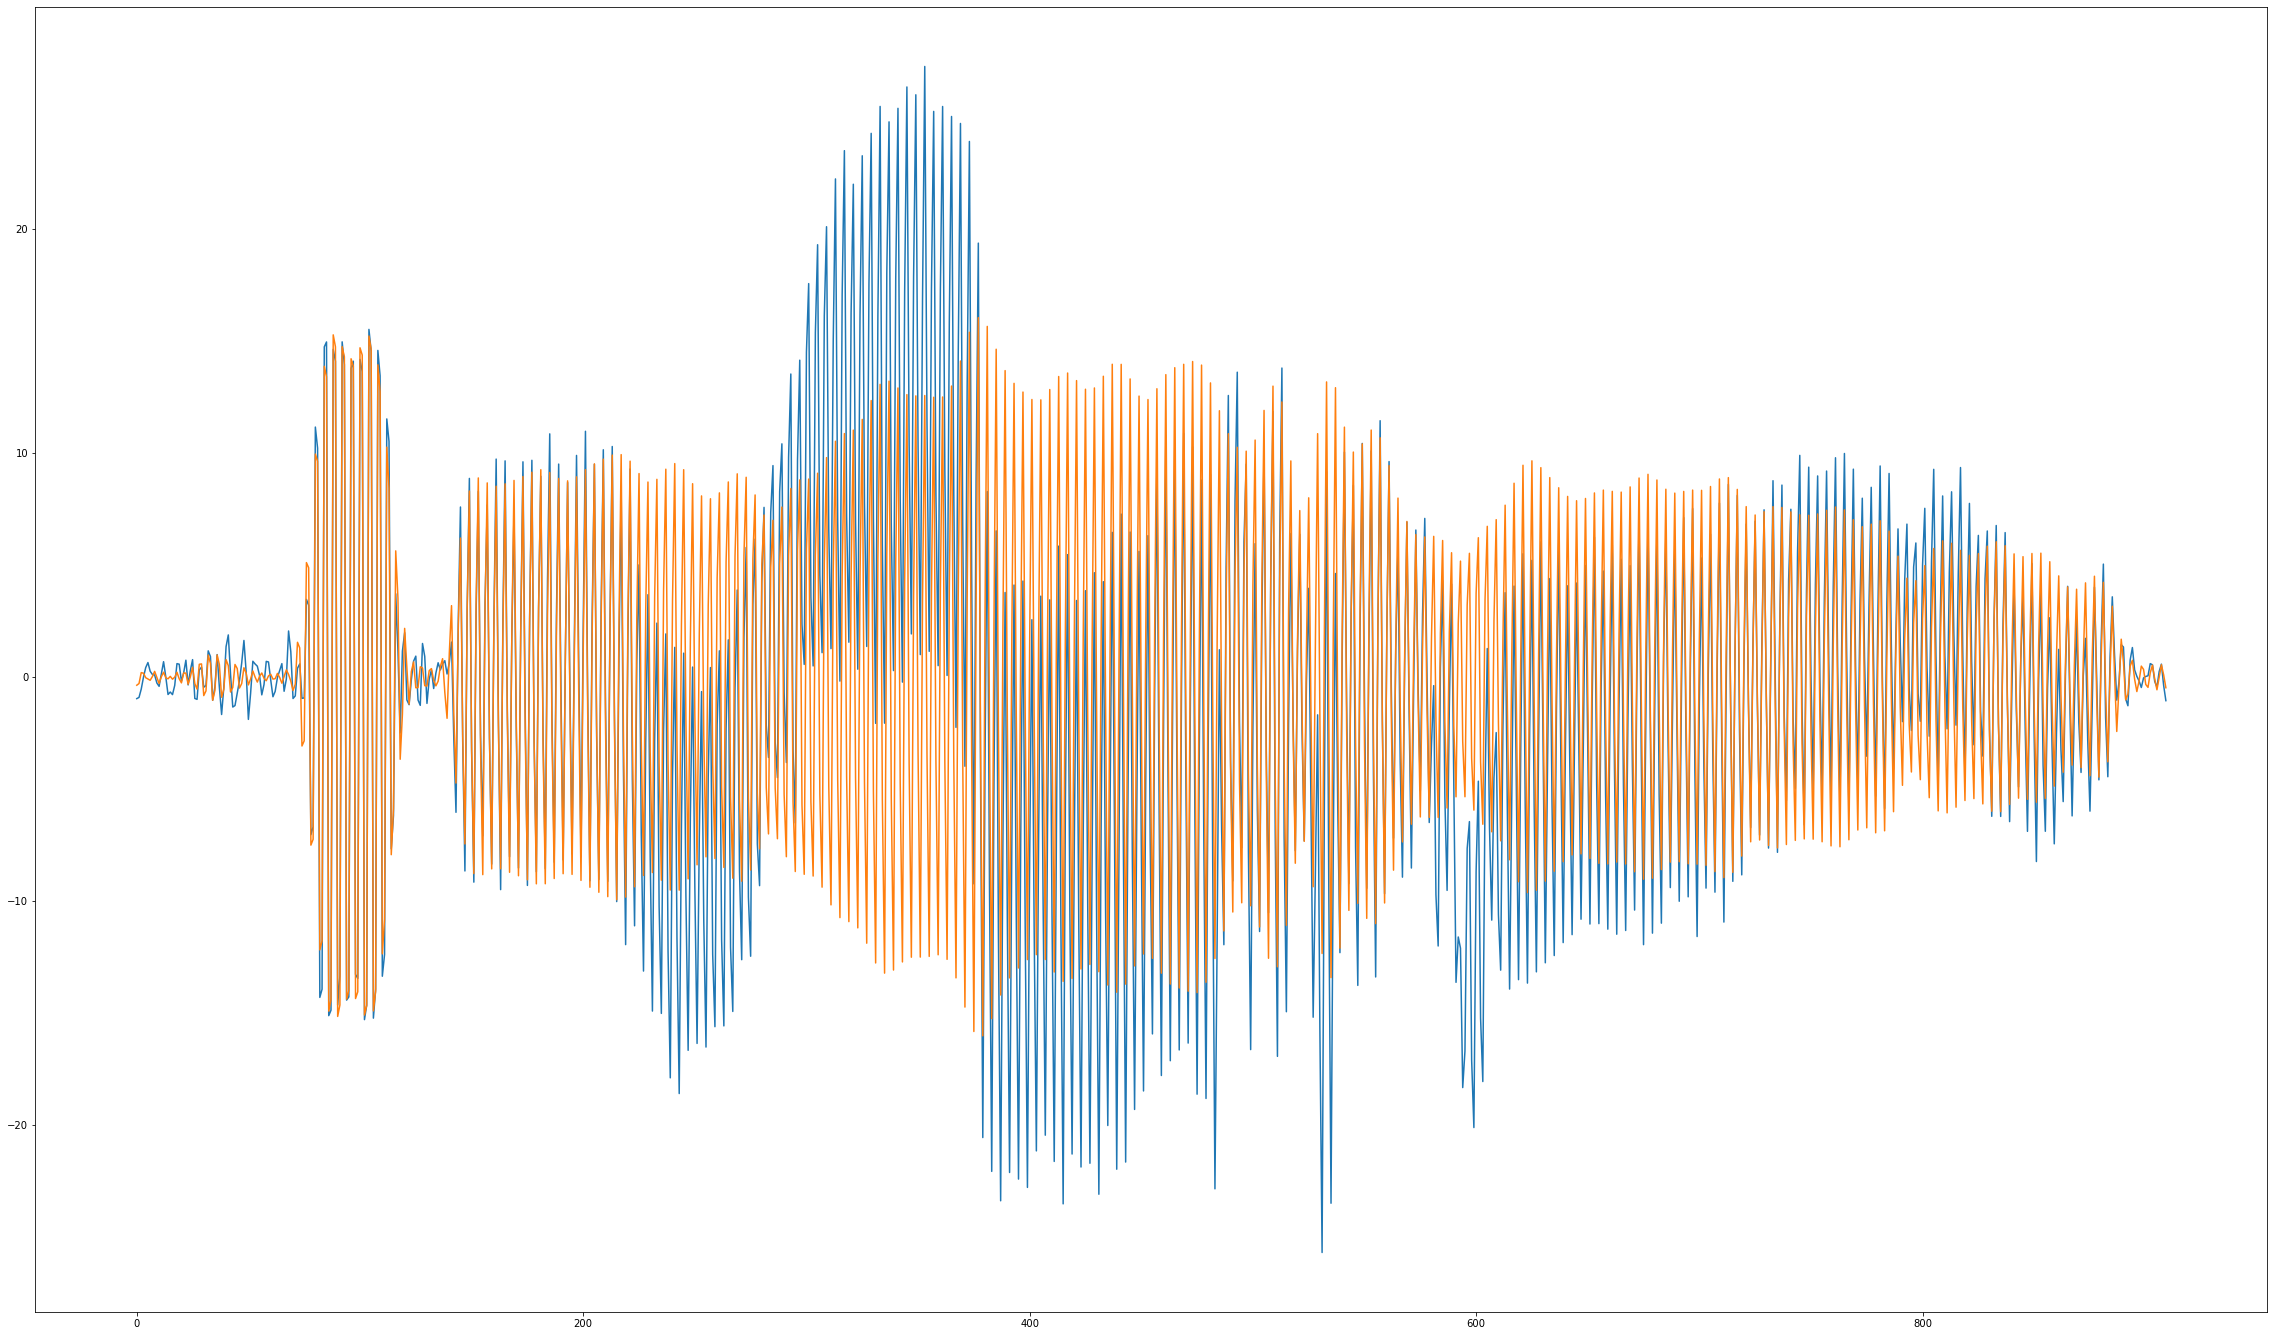

In [212]:
plt.plot(YC['C'][l])
plt.plot(YC['C'][l] - cf.ynotched[l])

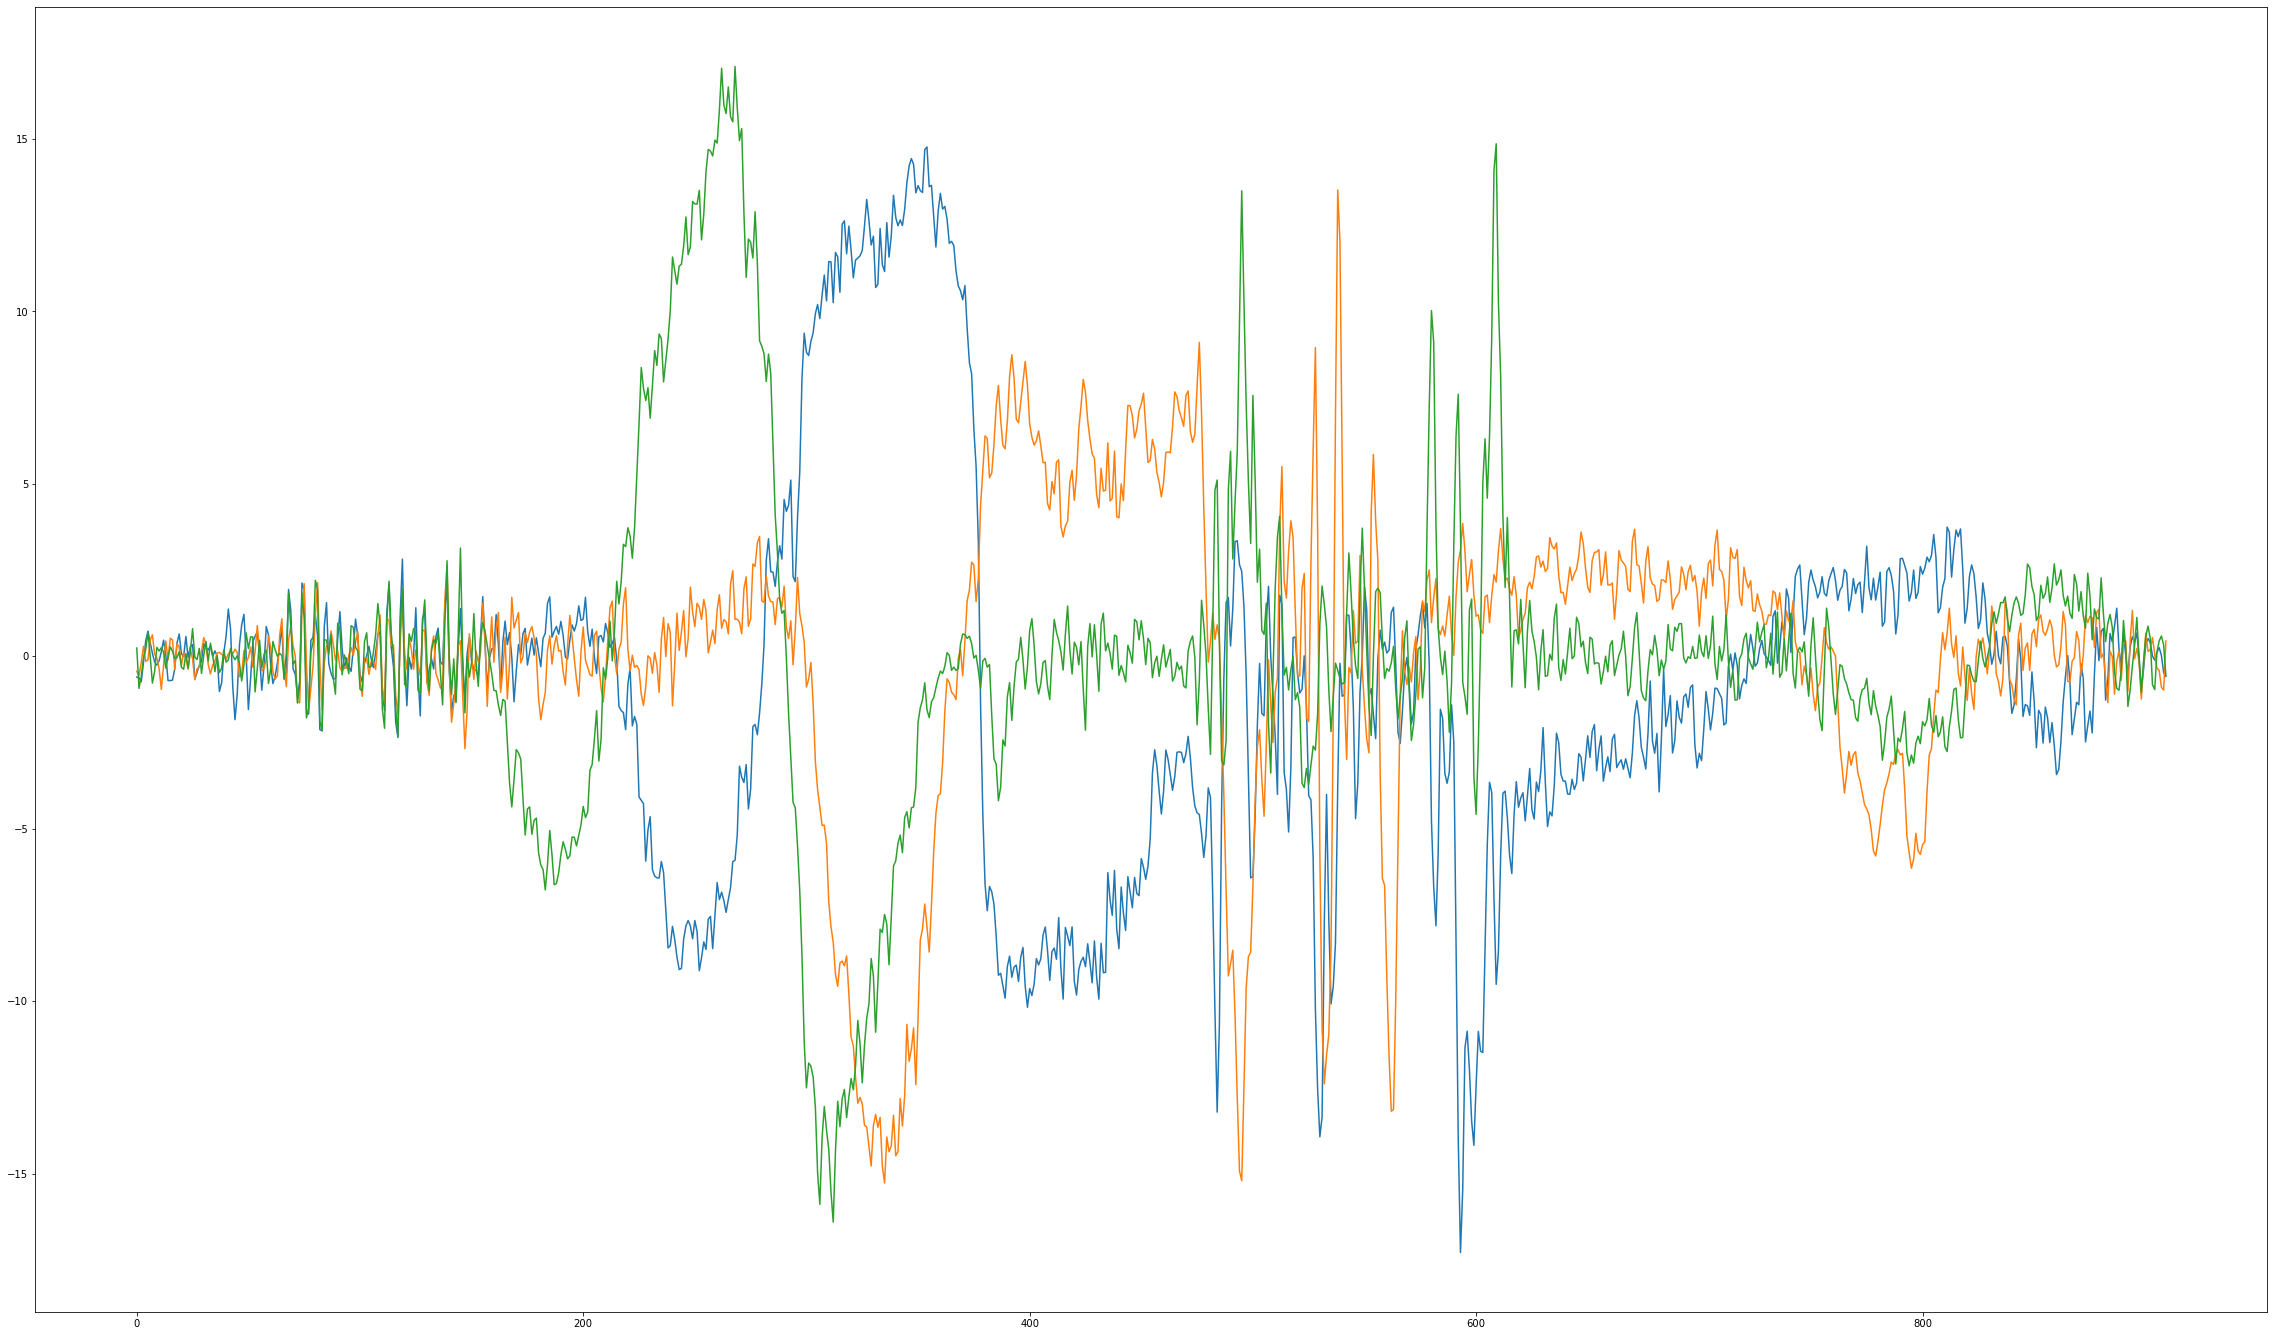

In [225]:
plt.plot(cf.ynotched[l])
plt.plot(cf.ynotched[l-2])
plt.plot(cf.ynotched[l+2])
#plt.plot(cf.cnotched[l])

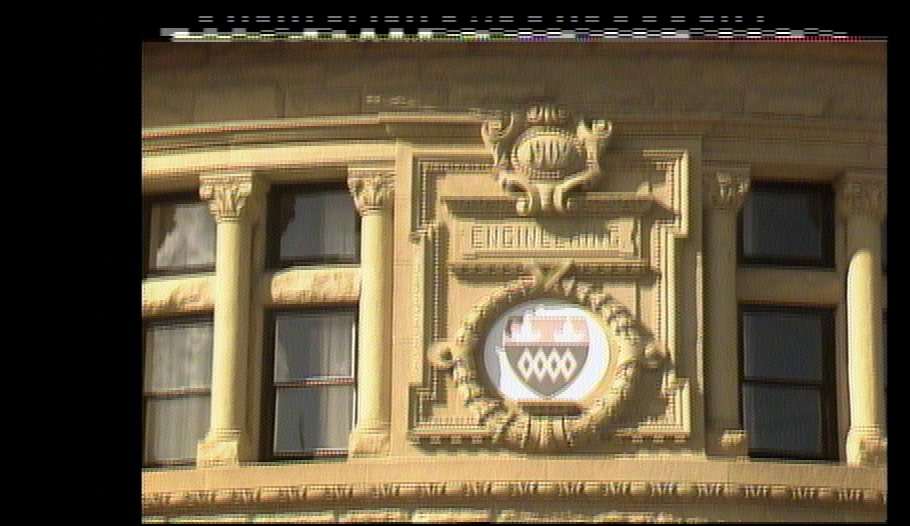

In [199]:
draw_u16_image(rgb_out16_field, 910, 263, 2)

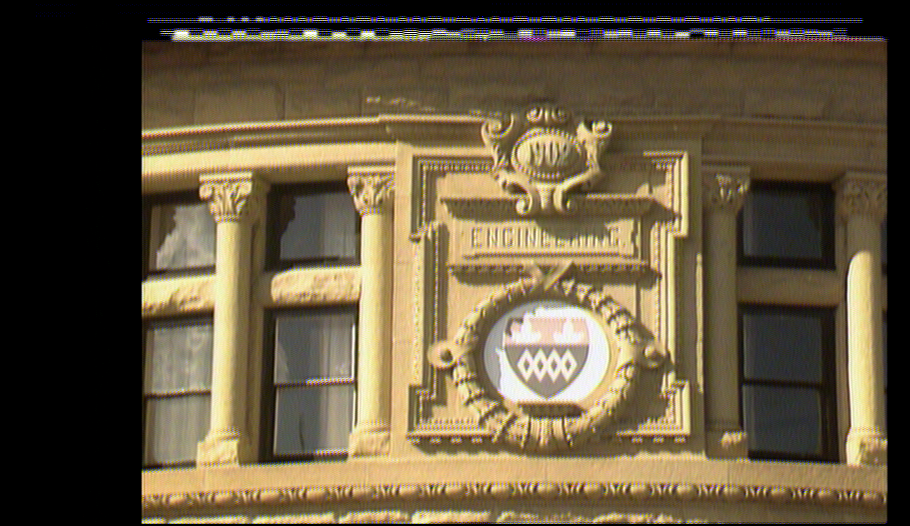

In [126]:
def draw_u16_image(pict, x = 910, y = 526, yscale = 1):
    rgb_out8 = np.clip(pict/256, 0, 255).astype(np.uint8).reshape((y, x * 3))
    rawimg = np.zeros((y * yscale, x * 3))
    for i in range(y * yscale):
        rawimg[i] = rgb_out8[i // yscale]
    im = Image.fromarray(rawimg.reshape((y * yscale, x, 3)).astype(np.uint8))
    b = BytesIO()
    im.save(b, format="png")

    return IPython.display.Image(b.getvalue(), width=x, height=y * yscale)

draw_u16_image(rgb_out16_frame)

In [138]:
with open('foo2.png', 'wb') as fp:
    fp.write(b.getbuffer())

In [127]:
IPython.display.Image?

In [117]:
rgb_out.shape

(526, 910, 3)

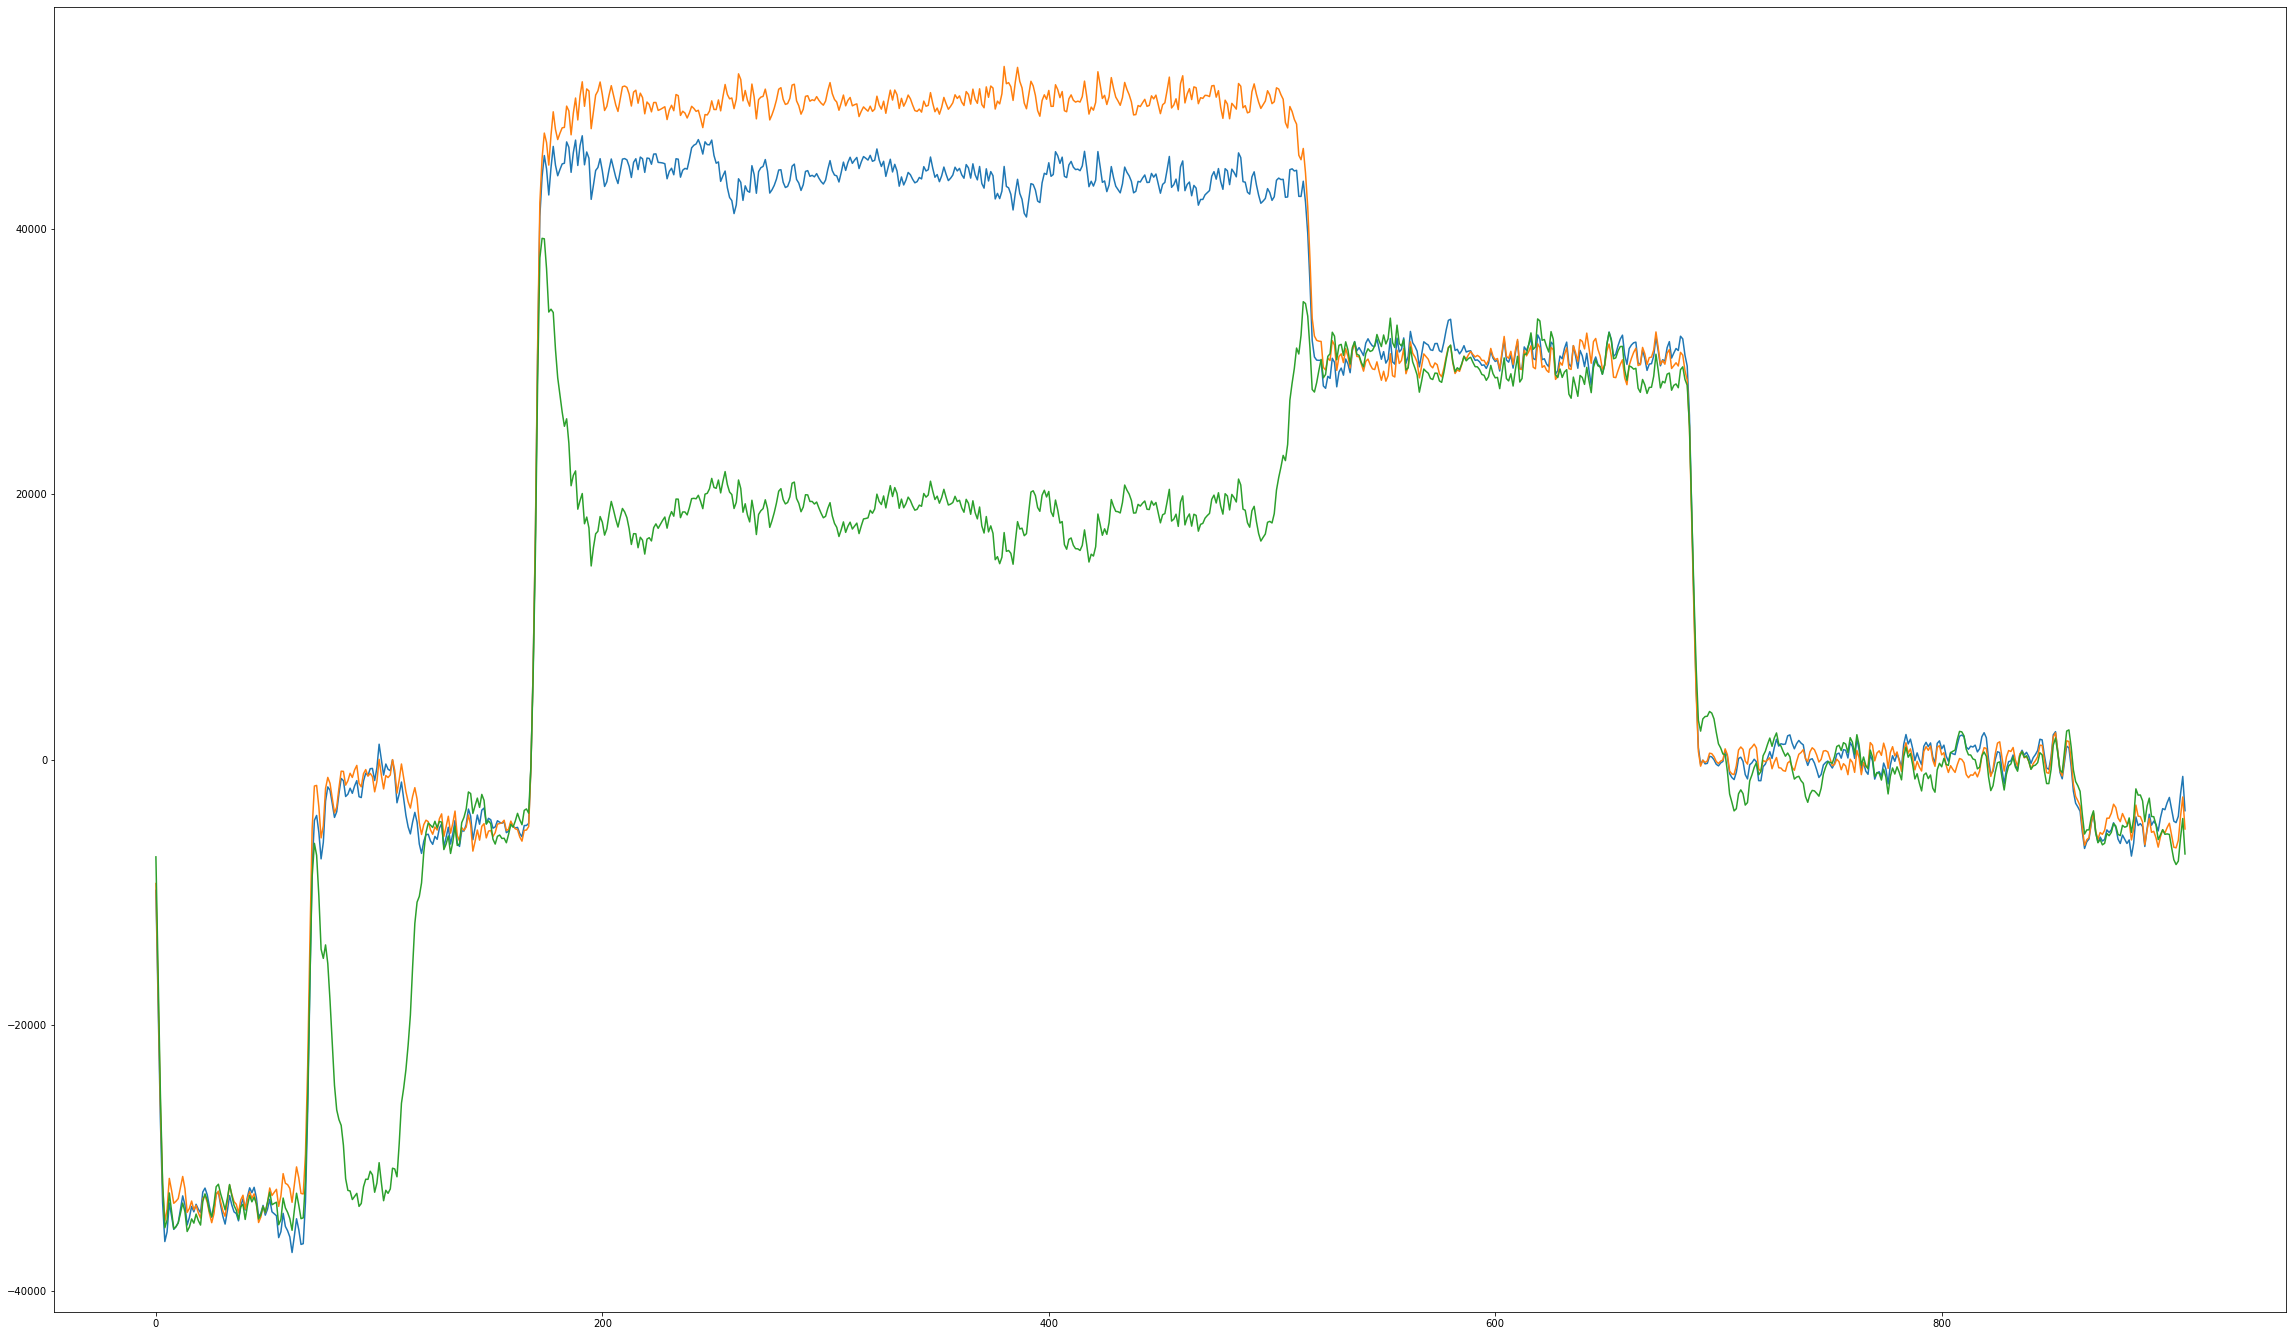

In [101]:
plt.plot(rgb_out[39])

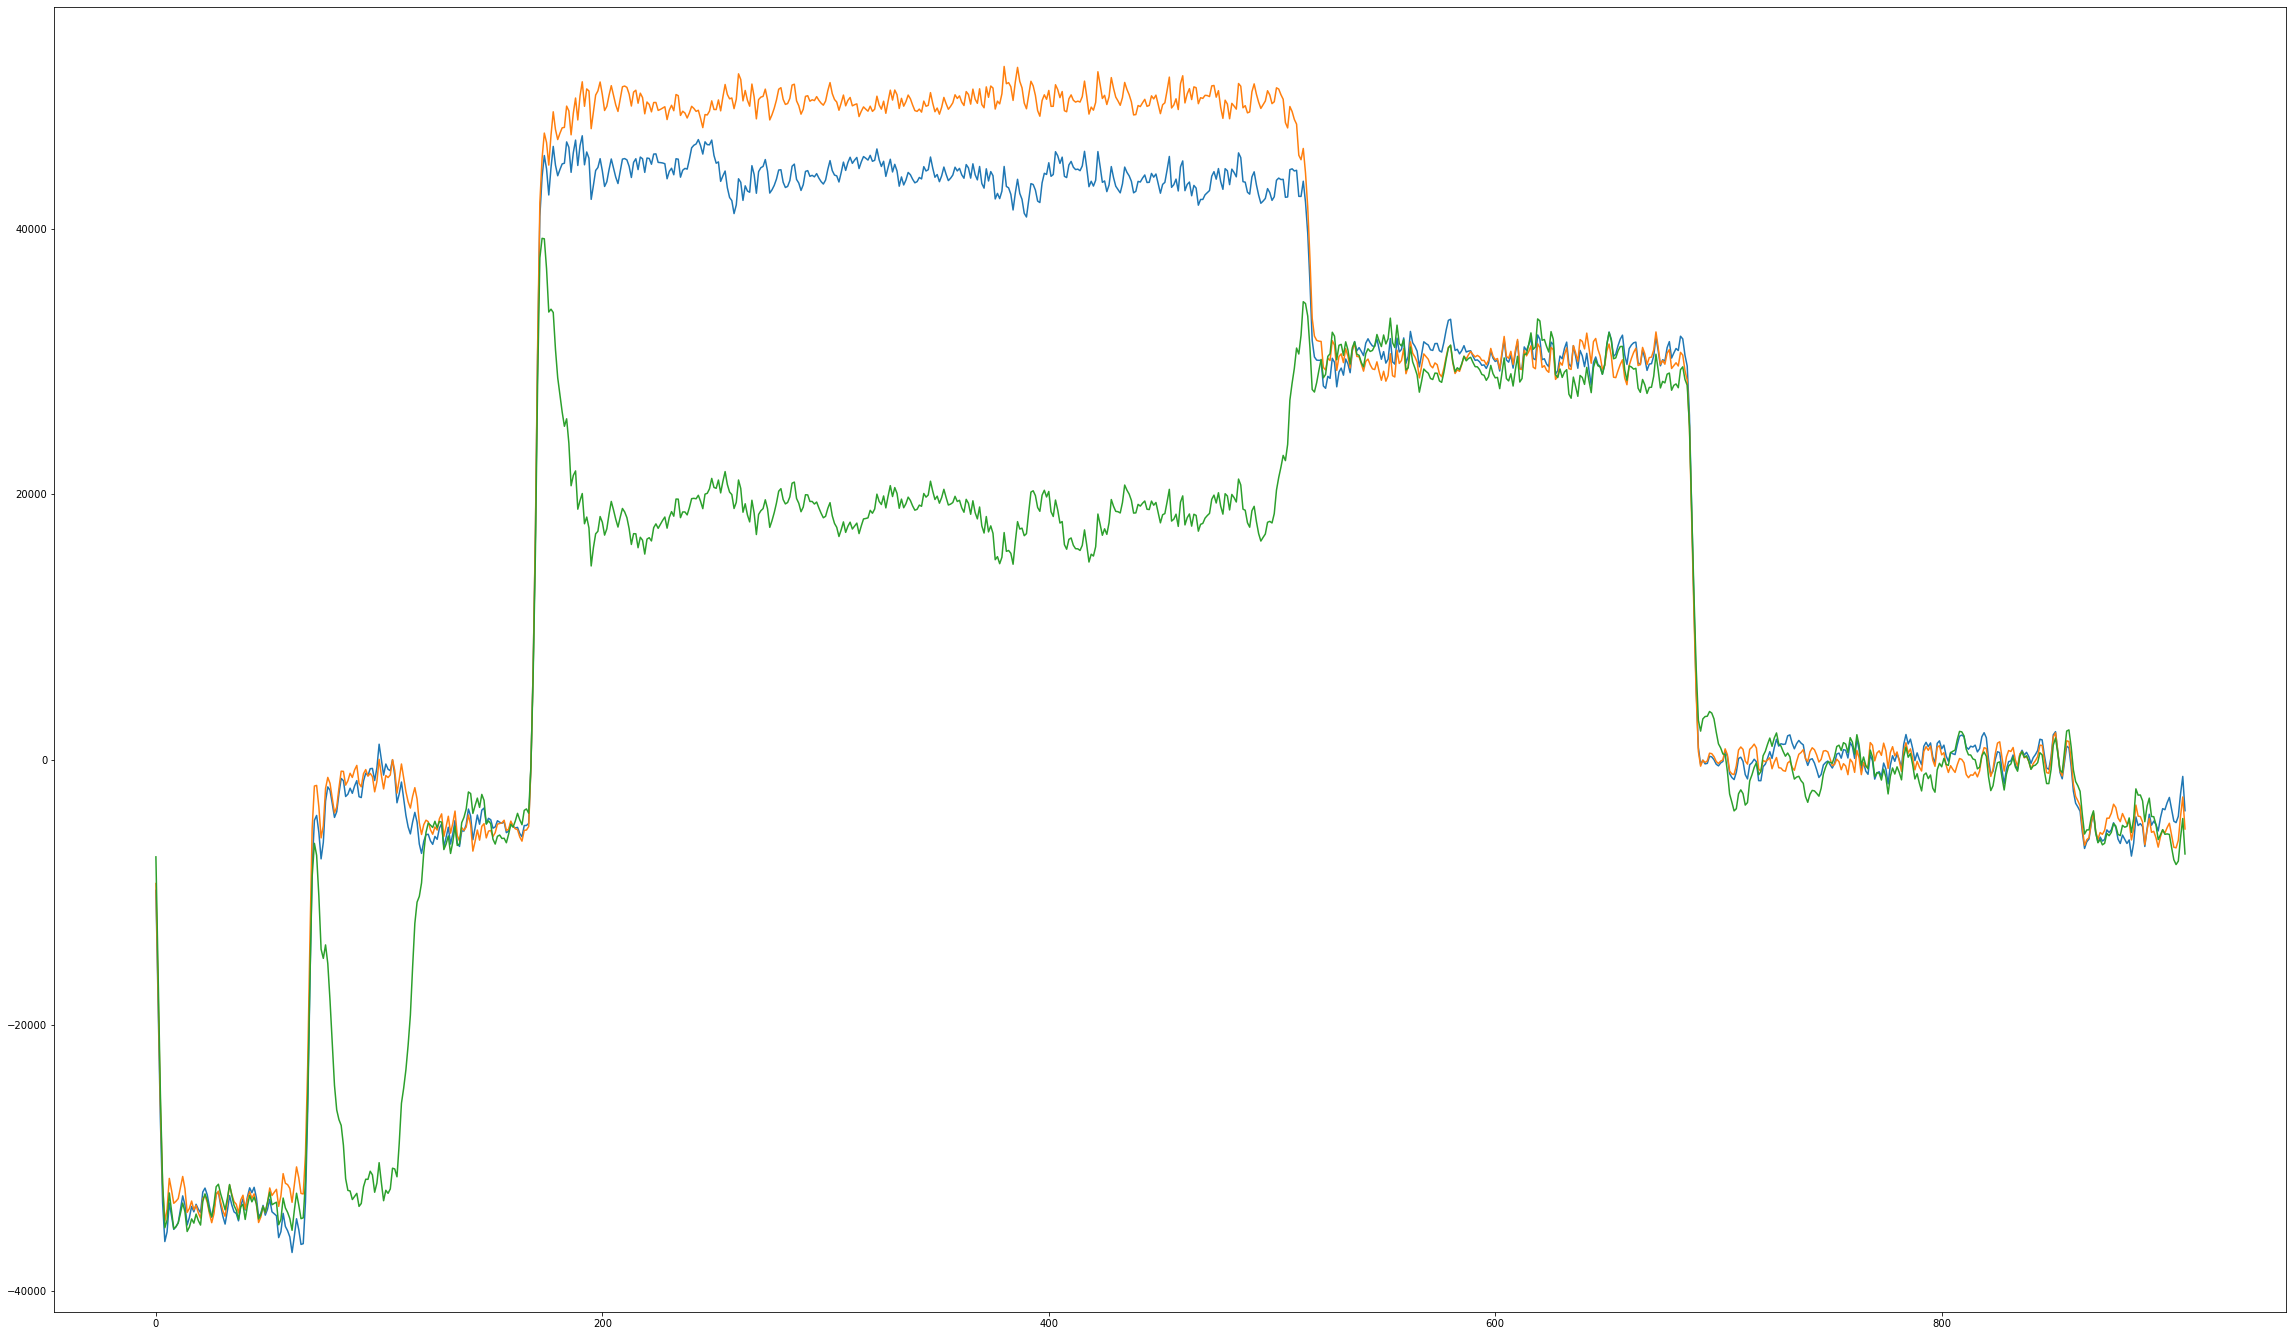

In [102]:
plt.plot(rgb_out[40])

In [286]:
cf = NotchComb()
rgb_out = np.zeros((526, 910, 3), dtype=np.float32)

if False:
    for fnum in [27000, 27001]:
        cf.load(tbc_fp, tbc_json, fnum)
        ydata, cdata = cf.process()
        cf.yc_to_rgb(rgb_out, ydata, cdata)
else:
    for fnum in [1]:
        cf.load(ctbc_fp, ctbc_json, fnum)
        ydata, cdata = cf.process()
        rgb_out = cf.yc_to_rgbx(ydata, cdata)

#rgb_out16 = rgb_out.clip(0,65535).reshape((526, 910*3)).astype(np.uint16)

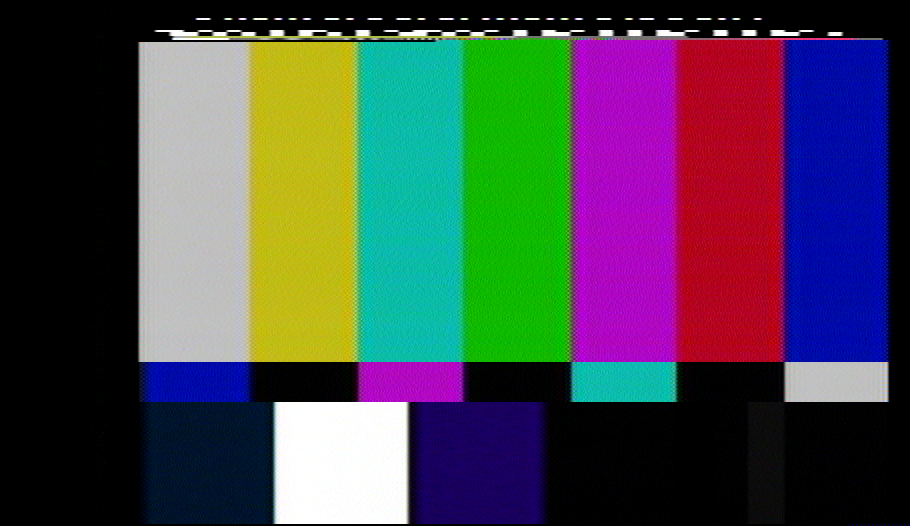

In [287]:
rgb_out = np.clip(rgb_out, 0, 255).astype(np.uint8).reshape((263, 910 * 3))
plines = 263
rawimg = np.zeros((plines * 2, 910 * 3))
for i in range(plines * 2):
    rawimg[i] = rgb_out[i // 2]
im = Image.fromarray(rawimg.reshape((plines * 2, 910, 3)).astype(np.uint8))
b = BytesIO()
im.save(b, format="png")

IPython.display.Image(
    b.getvalue(), width=int(910 * 1.0), height=int(plines * 1.0)
)


In [111]:
class LDS2Comb(NotchComb):
    def __init__(self, *args, **kwargs):
        super(LDS2Comb, self).__init__(*args, **kwargs)

    def process(self):
        ldata = self.indata.reshape((263, 910))

        pfilt = self.fc.prefilter(self.indata)
        
        self.ynotch  = self.fc.applyfilter('ynotch', pfilt, delay=len(self.ynotch)-1)
        
        self.ydata = np.zeros_like(ldata)
        self.cdata = np.zeros_like(ldata)

        #for i in range(1, 261):
        for i in range(1, 263 - 1):
            a = ldata[i - 1]
            b = ldata[i]
            c = ldata[i + 1]

            self.ydata[i] = ( a + 2*b + c) / 4
            self.cdata[i] = (-a + 2*b - c) / 4

        return self.ydata, self.cdata
        
cf = LDS2Comb()
cf.load(tbc_fp, tbc_json, 27000)
ydata, cdata = cf.process()
pdata = cf.yc_to_rgb(ydata, cdata)

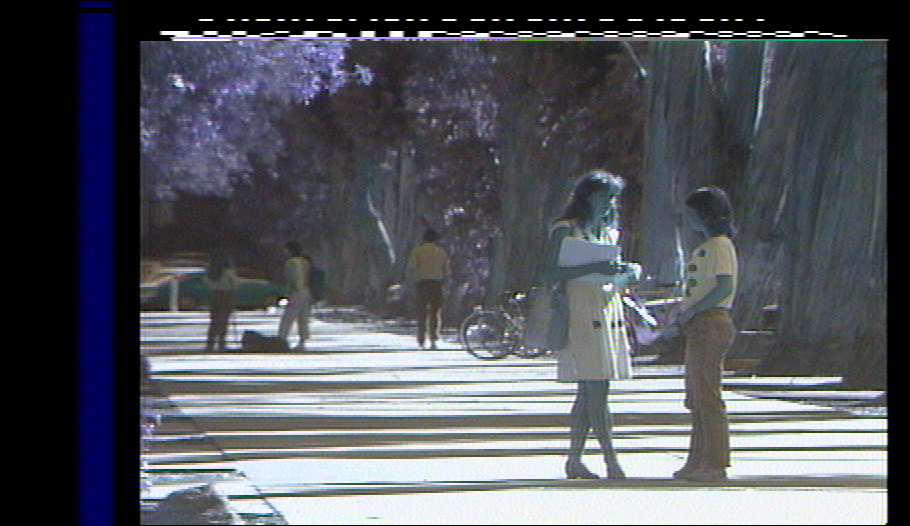

In [195]:
rgb_out = np.clip(rgb_out16/256, 0, 255).astype(np.uint8).reshape((526, 910 * 3))
plines = 526
rawimg = np.zeros((plines * 1, 910 * 3))
for i in range(plines * 1):
    rawimg[i] = rgb_out[i]
im = Image.fromarray(rawimg.reshape((plines, 910, 3)).astype(np.uint8))
b = BytesIO()
im.save(b, format="png")

IPython.display.Image(
    b.getvalue(), width=int(910 * 1.0), height=int(plines * 1.0)
)


In [181]:
717900/526

1364.828897338403

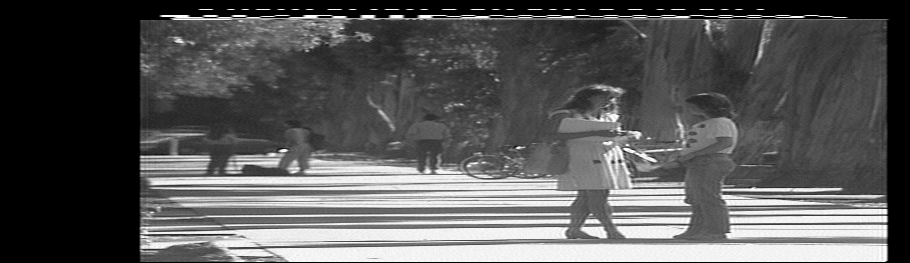

In [163]:
show = ydata
#show = cf.ydata
s8 = np.clip((show * 2.55), 0, 255).astype(np.uint8)

im = Image.fromarray(s8.reshape((263, 910)).astype(np.uint8))
b = BytesIO()
im.save(b, format="png")

IPython.display.Image(
    b.getvalue(), width=int(910 * 1.0), height=int(plines * 1.0)
)
